In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from keras.activations import sigmoid
from keras.models import Model ,load_model
from keras.layers import Input, Dense, ConvLSTM2D, Conv2D, Conv1D, MaxPooling2D, Layer, GlobalAveragePooling2D, Reshape, Flatten, BatchNormalization, Bidirectional
from keras.regularizers import L2
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers.legacy import Adam
from keras.saving import register_keras_serializable
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from scipy.sparse.linalg import cg


In [21]:
# dirs
DATA_DIR = "./load.csv"

In [22]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [23]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [24]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [25]:
data.describe()

,Timestamp,Load
count,35040,35040.000000
mean,2023-07-02 11:52:30,0.363028
min,2023-01-01 00:00:00,0.000000
25%,2023-04-02 05:56:15,0.260656
50%,2023-07-02 11:52:30,0.319672
75%,2023-10-01 17:48:45,0.415574
max,2023-12-31 23:45:00,1.000000
std,NaN,0.145213


In [26]:
"""
!! parameter settings
n_predict: predict steps
height: final height of the image:
            height * 2 if the n_predict <= width,
            height * 2 + 1 if the n_predict > width
width: width of the image
n_days: use past n days historical time series data as input (number of channel)
n_window_shift: the shift interval of sliding window
"""
n_predict = 2
height = 8
width = 12
n_days = 3
n_window_shift = "15min"

In [27]:
class TimeSeriesImageCoder():
    def __init__(
            self,
        X: pd.DataFrame,
        n_predict: int,
        height: int,
        width: int,
        n_days: int,
        n_window_shift: str
    ) -> None:
        self.X = X
        self.h = height
        self.m = width
        self.d_b = n_days
        self.shift = n_window_shift
        self.n_predict = n_predict
        self.Lb = self.h * self.m
        self.Ls = math.ceil(self.n_predict / self.m) * self.m
        self.timestamps = self.generate_timestamps()
        print(f"Lb: {self.Lb}")
        print(f"Ls: {self.Ls}")

    def generate_timestamps(self):
        start = self.X['Timestamp'].min() + DateOffset(days=3)
        end = self.X['Timestamp'].max() - DateOffset(minutes=96*15)
        timestamps = pd.date_range(start=start, end=end, freq=self.shift)
        return timestamps
    
    def __make_it_symmetric_3d(self, sets_3d):
        symmetry_training_sets = []
        for slice_2d in np.array(sets_3d):
            reversed_slice_2d = slice_2d[::-1]
            combined_slice_2d = np.concatenate((slice_2d, reversed_slice_2d), axis=0)
            symmetry_training_sets.append(combined_slice_2d)
        return np.array(symmetry_training_sets)
    
    def __make_it_symmetric_2d(self, sets_2d):
        reversed_slice_2d = sets_2d[::-1]
        combined_slice_2d = np.concatenate((sets_2d, reversed_slice_2d), axis=0)
        return np.array(combined_slice_2d)
    

    def encode_b(self):
        training_sets = []
        target_sets = []
        self.X_timeseries_flatten = []
        self.X_timestamp = []
        self.y_timestamp = []
        for steps in self.timestamps:
            training_start_b = steps - DateOffset(days=self.d_b-1, hours=23, minutes=45)
            training_end = steps
            target_start = training_end + DateOffset(minutes=15)
            target_end = steps + DateOffset(minutes=(self.n_predict)*15)
            training_data = self.X[(self.X['Timestamp'] >= training_start_b) & (self.X['Timestamp'] <= training_end)]
            target_data = self.X[(self.X['Timestamp'] >= target_start) & (self.X['Timestamp'] <= target_end)]
            if not training_data.empty and not target_data.empty:
                self.X_timeseries_flatten.append(training_data['Load'])
                self.X_timestamp.append(training_data['Timestamp'])
                self.y_timestamp.append(target_data['Timestamp'])
                training_reshaped = np.array(training_data['Load']).reshape(self.d_b, self.h, self.m)
                # symmetric_3d = self.__make_it_symmetric_3d(training_reshaped)
                training_sets.append(training_reshaped)
                target_reshaped = np.array(target_data['Load']).reshape(math.ceil(self.n_predict/self.m), min(self.n_predict, self.m))
                # symmetric_2d = self.__make_it_symmetric_2d(target_reshaped)
                target_sets.append(target_reshaped.flatten())
        training_sets = np.array(training_sets)
        target_sets = np.array(target_sets)

        self.X_timeseries_flatten = np.array(self.X_timeseries_flatten)
        self.X_timestamp = np.array(self.X_timestamp)
        self.y_timestamp = np.array(self.y_timestamp)
        return training_sets, target_sets
    
    def encode(self):
        training_sets_b, target_sets = self.encode_b()
        # training_sets_s = self.encode_s()
        training_sets_b = np.transpose(training_sets_b, (0, 2, 3, 1))
        # training_sets_s = np.transpose(training_sets_s, (0, 2, 3, 1))
        return training_sets_b, target_sets
    
    """calculate the final output of model prediction"""
    def __sum_np(self, matrix):
        n_pairs = len(matrix) // 2
        sums = []
        for i in range(n_pairs):
            sums.append(list(map(sum, zip(matrix[i], matrix[-(i + 1)]))))
        if len(matrix) % 2 != 0:
            sums.append(matrix[n_pairs])

        return [num for row in sums for num in row]
    
    def __x_timeseries_to_image(self, vector):
        matrix_1d = vector.reshape(self.d_b, self.h, self.m)
        image = self.__make_it_symmetric_3d(matrix_1d)
        return image
    
    def pairwise_sum(self, matrix):
        summed_3d_np = np.array([self.__sum_np(layer) for layer in matrix]) / 2
        return summed_3d_np
    
    """Use predictions from previous steps to add new inputs to rolling predictions"""
    def image_shift(self, original_input, new_input):
        input = np.transpose(original_input, (0, 3, 1, 2))
        output = []
        output.append(self.pairwise_sum(input[0]))
        output = np.array(output).flatten()
        output = np.concatenate([output, new_input], axis=0)[-len(output):]
        image = self.__x_timeseries_to_image(output)
        image = image.reshape(1, *image.shape)
        image = np.transpose(image, (0, 2, 3, 1))
        return image


In [28]:
encoder = TimeSeriesImageCoder(
    X=data,
    n_predict=n_predict,
    height=height,
    width=width,
    n_days=n_days,
    n_window_shift=n_window_shift
)
encoded_Xb, encoded_y = encoder.encode()
X_timeseries = np.copy(encoder.X_timeseries_flatten)
X_timestamp = np.copy(encoder.X_timestamp)
y_timestamp = np.copy(encoder.y_timestamp)

Lb: 96
Ls: 12


In [29]:
print(encoded_Xb.shape)
print(encoded_y.shape)

print(X_timeseries.shape)
print(X_timestamp.shape)
print(y_timestamp.shape)

(34656, 8, 12, 3)
(34656, 2)
(34656, 288)
(34656, 288)
(34656, 2)


In [30]:
MONTH_TIME_STEP = math.floor(encoder.timestamps.shape[0] / 24)
X_test_b = []
y_test = []
X_test_b_flatten = []
X_test_b_timestamp = []
y_test_timestamp = []

for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test_b.append(encoded_Xb[start:end])
    y_test.append(encoded_y[start:end])
    X_test_b_flatten.append(X_timeseries[start:end])
    X_test_b_timestamp.append(X_timestamp[start:end])
    y_test_timestamp.append(y_timestamp[start:end])


    encoded_Xb = np.concatenate([encoded_Xb[:start], encoded_Xb[end:]])
    encoded_y = np.concatenate([encoded_y[:start], encoded_y[end:]])
    X_timeseries = np.concatenate([X_timeseries[:start], X_timeseries[end:]])
    X_timestamp = np.concatenate([X_timestamp[:start], X_timestamp[end:]])
    y_timestamp = np.concatenate([y_timestamp[:start], y_timestamp[end:]])


In [31]:
 
X_test_b = np.concatenate([i for i in X_test_b])
y_test = np.concatenate([i for i in y_test])
X_test_b_flatten = np.concatenate([i for i in X_test_b_flatten])
X_test_b_timestamp = np.concatenate([i for i in X_test_b_timestamp])
y_test_timestamp = np.concatenate([i for i in y_test_timestamp])




In [32]:
X_train_b = encoded_Xb
y_train = encoded_y

In [33]:
print(np.array(X_train_b).shape)
print(np.array(X_test_b).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(X_test_b_flatten.shape)
print(X_test_b_timestamp.shape)
print(y_test_timestamp.shape)

(30048, 8, 12, 3)
(4608, 8, 12, 3)
(30048, 2)
(4608, 2)
(4608, 288)
(4608, 288)
(4608, 2)


In [86]:
def visualize_multiple_images(data, rows=20, cols=4):
    plt.figure(figsize=(15, 13))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(data[i])
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    plt.savefig("RGB_img.png", dpi=1300)
    plt.show()

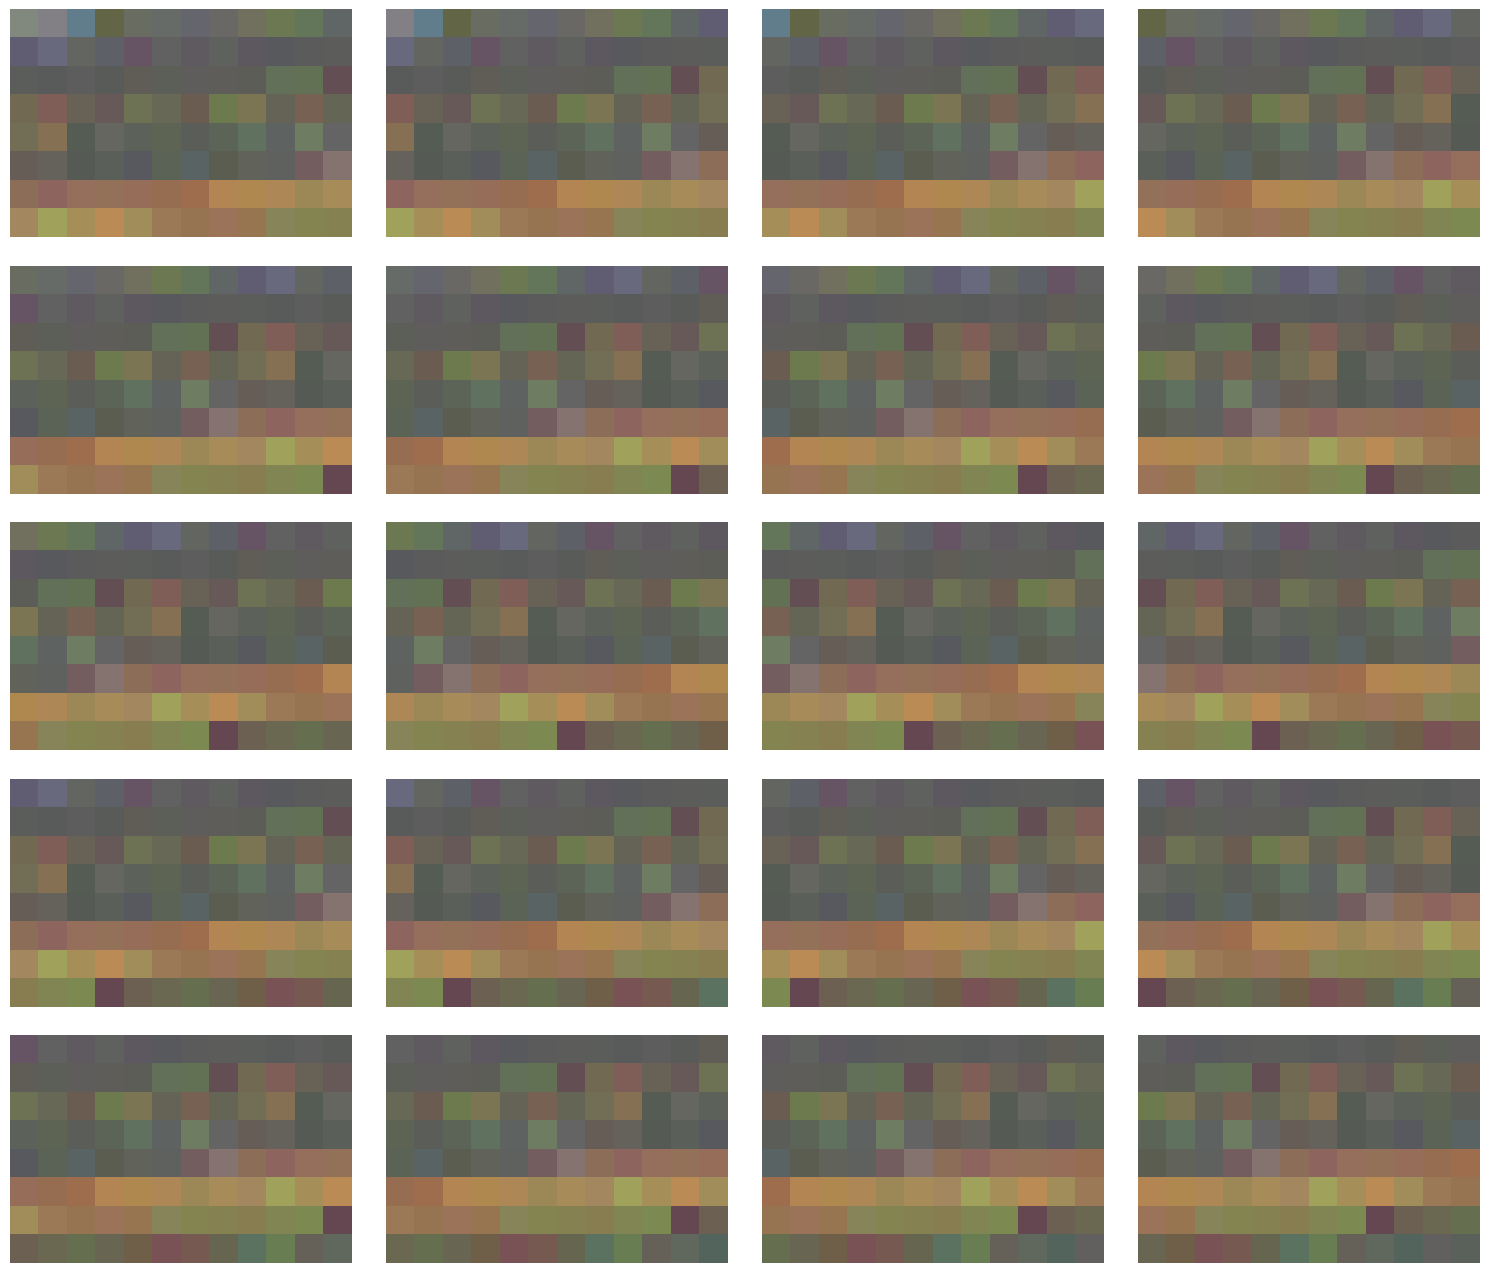

In [87]:
visualize_multiple_images(X_train_b[1020:1041], rows=5, cols=4)